In [569]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

#from keras.layers.normalization import BatchNormalization
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import matplotlib.pyplot as plt

In [517]:
# import libraries 
import pandas as pd
# pd take screen width
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
%matplotlib inline

arabic_stopwords = set(nltk.corpus.stopwords.words("arabic"))

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations = arabic_punctuations + english_punctuations


def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text


def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text

# def remove_emoji(text):
#     return emoji.get_emoji_regexp().sub(u'', text)

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def normalization(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in arabic_stopwords]
    return ' '.join(filtered_sentence)

def cleaning_content(line):
    if (isinstance(line, float)):
        return None
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    line = remove_emoji(line)
    nline = [w if '@' not in w else 'USERID' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '').replace('USERID', '')


    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in punctuations}))

    # then remove punc,
    translator = str.maketrans('', '', punctuations)
    line = line.translate(translator)

    line = remove_stopwords(line)
    line=remove_diacritics(normalization(line))
    if line != '':
        return line

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)


In [518]:
df = pd.read_csv('../DataSet/All_Data_Racism.csv')

In [519]:
mor_rac = pd.read_csv('../DataSet/semi_assisted_moroccanracism_annotated.csv')
mor_rac2 = pd.read_csv('../DataSet/semi_assisted_moroccanracism_annotated2.csv')
mor_rac3 = pd.read_csv('../DataSet/semi_assisted_moroccanracism_annotated3.csv')
mor_rac4 = pd.read_csv('../DataSet/semi_assisted_moroccanracism_annotated4.csv')
rac5 = pd.read_csv('../DataSet/semi_assisted_racism_annotated_usingLSTM.csv', encoding='utf-16')
rac6 = pd.read_csv('../DataSet/handcollected.csv')

racism = pd.concat(
                    [mor_rac[mor_rac['label'] == 'Racism'], 
                    mor_rac2[mor_rac2['label'] == 'Racism'],
                    mor_rac3[mor_rac3['label'] == 'Racism'],
                    mor_rac4[mor_rac4['label'] == 'Racism'], 
                    rac5[rac5['label'] == 'Racism'],
                    rac6[rac6['label'] == 'Racism']], ignore_index=True)
racism

,text,label
0,"🤣🤣🤣🤣 هادي نظرية جديدة ""نظرية سلاوية الأرض""",Racism
1,": ها علاش اوروبا مبقاوش يحملو العرب هد النوعية الهيطوكية مالين ثقافة ""كلشي ديال الله"" هي لوسخاتها وطيحت بالسمعة ديالنا htt…",Racism
2,: أي بروفيل فيه هاد العلامات ب 3 عرفو زبل إلكتروني : 1 - ترويج أخبار سلبية صحيحة أو كاذبة عن قطر و تركيا 2 - ترويج أخبار جيدة…,Racism
3,الأسود الداكن,Racism
4,: باش يوصل الفكر الاجرامي دبنادم تا لهاد الدرجة...فراه فعلاا الحضييييض...تخرج عادي حيث ملزم تمشي للخدمة وتقد تهز كورونا فا…,Racism
...,...,...
68,وا لكحل وا لعزي وا كحل لعفتا,Racism
69,وا شلح وا زقرام,Racism
70,هاد رباتيين مخنتين امبنتين,Racism
71,كاساوا حادڭين غا ف لهاماج,Racism


In [520]:
s =  mor_rac4[mor_rac4['label'] == 'not racism']
s2 =mor_rac3[mor_rac3['label'] == 'not racism']
s3 = mor_rac2[mor_rac2['label'] == 'not racism']

notracism =pd.concat([s,s2,s3], ignore_index=True)

notracism = notracism.iloc[0:69]

notracism = pd.DataFrame(notracism)

notracism

,text,label
0,﴿يَا أَيُّهَا الَّذِينَ آمَنُوا اتَّقُوا اللَّهَ حَقَّ تُقَاتِهِ وَلَا تَمُوتُنَّ إِلَّا وَأَنْتُمْ مُسْلِمُونَ﴾🥀\r\nمن قرأها يضع قلب ويتابعنا فضلاً ❣️💛 🧡 💚 💙 ❤️,not racism
1,فلوسي نقول ليهم لي بغيت ههه,not racism
2,اشياء مشتركة بين بلدان المغرب العربي.,not racism
3,واحد ناس حدايا ولد 2019 سماوه بوجمعة 😔😔😔😔بقا فيا الدري والمشكل باباه سميتو زكريا 🤣🤣🤣🤣🤣 فهم تسطى,not racism
4,الله يرحم لكم الوالدين شكون لي تعاون معي على وجه الله يشري ليا جوج خناشي ديال الدقيق بغيت نعجن الخبز ونبيعه في الزنقه راه وصلت لي العظم ما لقيت الحنين لا رحم انا وبنتي وتجمع علي الكراء بغيت نخرج نخدم شويه باش نلقى باش نكون مع الوقت الله يرحم لكم الوالدين الله يجعلها في ميزان حسناتكم تعاونوا معي انا اختكم ارمله 0627019677 مراكش,not racism
...,...,...
64,قالو_ناس_زمان بنادم هو لي يبقا فصباغتو ماشي إتلون وقتما بغا حاجتو,not racism
65,نمشيو نعسو واحد شوية بينما توصل 3:00,not racism
66,علِّموا_أولادكم أن الدين ليس فقط صيام و صلاة و كلام منمق يلقى في المساجد و إنما الدين معاملة و حياة,not racism
67,علِّموا_أولادكم أنهم ليسوا بحاجة لأن يكونوا ببغاوات مقلدين غربا وشرقا فحضارة الإسلام هى من نقلت مشاعل النور لأوروبا,not racism


In [521]:
# delete duplicates
racism = racism.drop_duplicates(subset=['text'], keep='first')

mor_rac = pd.concat([racism, notracism], ignore_index=True)

mor_rac

,text,label
0,"🤣🤣🤣🤣 هادي نظرية جديدة ""نظرية سلاوية الأرض""",Racism
1,": ها علاش اوروبا مبقاوش يحملو العرب هد النوعية الهيطوكية مالين ثقافة ""كلشي ديال الله"" هي لوسخاتها وطيحت بالسمعة ديالنا htt…",Racism
2,: أي بروفيل فيه هاد العلامات ب 3 عرفو زبل إلكتروني : 1 - ترويج أخبار سلبية صحيحة أو كاذبة عن قطر و تركيا 2 - ترويج أخبار جيدة…,Racism
3,الأسود الداكن,Racism
4,: باش يوصل الفكر الاجرامي دبنادم تا لهاد الدرجة...فراه فعلاا الحضييييض...تخرج عادي حيث ملزم تمشي للخدمة وتقد تهز كورونا فا…,Racism
...,...,...
133,قالو_ناس_زمان بنادم هو لي يبقا فصباغتو ماشي إتلون وقتما بغا حاجتو,not racism
134,نمشيو نعسو واحد شوية بينما توصل 3:00,not racism
135,علِّموا_أولادكم أن الدين ليس فقط صيام و صلاة و كلام منمق يلقى في المساجد و إنما الدين معاملة و حياة,not racism
136,علِّموا_أولادكم أنهم ليسوا بحاجة لأن يكونوا ببغاوات مقلدين غربا وشرقا فحضارة الإسلام هى من نقلت مشاعل النور لأوروبا,not racism


In [522]:
mor_rac.label.value_counts()

Racism        69
not racism    69
Name: label, dtype: int64

In [523]:
df = pd.concat([df, mor_rac], ignore_index=True)

df

,Unnamed: 0,text,label,Majority_Label,id
0,0.0,معتوه يحاول استثمار العنصريه اجل الفوز الشخص اجر قطعه ارض منهاتن نيورك للقذافي زيارته لتلك المدينه اجل نصب فيها خيمته واليوم هو يتنكر للعرب والمسلمين,Racism,NaN,NaN
1,1.0,كول هذا هوا خنزير الخنازير اما الصهاينه نهايتهم للدعس تفه,Racism,NaN,NaN
2,2.0,واش هي منيتكم اشوف الزمر تشطح السيده منصور معاها اشنو كاي الهدف هادشي,not racism,NaN,NaN
3,3.0,كسم السيسي علي كسم ال دعم السيسي يوم حتي دنا كنت اعدادي بشخه واقول للعيال الدروس العسكري هينيكك وينهبك زي مب بقاله 60 سنه بيعمل ايه واله بيبداها دم مستحيل تشوف خير كانوا يتنمروا عليا ويقولوا عليا اخوان ولاد الاحبه نصهم اهاليهم بتشحت دلوقت,Racism,NaN,NaN
4,4.0,السعوديه هي اطهر ارض وشعب واحقر شعب,Racism,NaN,NaN
...,...,...,...,...,...
2019,NaN,قالو_ناس_زمان بنادم هو لي يبقا فصباغتو ماشي إتلون وقتما بغا حاجتو,not racism,NaN,NaN
2020,NaN,نمشيو نعسو واحد شوية بينما توصل 3:00,not racism,NaN,NaN
2021,NaN,علِّموا_أولادكم أن الدين ليس فقط صيام و صلاة و كلام منمق يلقى في المساجد و إنما الدين معاملة و حياة,not racism,NaN,NaN
2022,NaN,علِّموا_أولادكم أنهم ليسوا بحاجة لأن يكونوا ببغاوات مقلدين غربا وشرقا فحضارة الإسلام هى من نقلت مشاعل النور لأوروبا,not racism,NaN,NaN


In [524]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)


In [525]:
df.label.value_counts()

not racism    1119
Racism         905
Name: label, dtype: int64

In [526]:
# balance the data
# df = df.groupby('label').apply(lambda x: x.sample(df.label.value_counts().min(), random_state=1)).reset_index(drop=True)


In [527]:
# df.label.value_counts()

In [528]:
# clean the data
df['text'] = df['text'].apply(cleaning_content)

# select only strings
df = df[df['text'].apply(lambda x: isinstance(x, str))]

In [529]:
max_len = df['text'].apply(lambda x: len(str(x).split())).max()

# split the data

y =  df.label.values

encodedict = {'not racism': 0, 'Racism': 1}
y = np.array([encodedict[item] for item in y])

xtraingru, xvalidgru, ytraingru, yvalidgru = train_test_split(df.text.values, y, test_size = 0.2, random_state = 42, stratify= df.label.values, shuffle = True)


In [530]:
# Using Keras Tokenizer:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
token = Tokenizer()
token.fit_on_texts(list(xtraingru) + list(xvalidgru))

xtrain_seq = token.texts_to_sequences(xtraingru)
xvalid_seq = token.texts_to_sequences(xvalidgru)
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [440]:
# RNN model 
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 218, 300)          2355000   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 101       
Total params: 2,395,201
Trainable params: 2,395,201
Non-trainable params: 0
_________________________________________________________________


In [441]:
model.fit(xtrain_pad, ytraingru, epochs = 20)

Epoch 1/20
46/46 [==============================] - 13s 277ms/step - loss: 0.5906 - accuracy: 0.6637
Epoch 2/20
46/46 [==============================] - 13s 280ms/step - loss: 0.1222 - accuracy: 0.9751
Epoch 3/20
46/46 [==============================] - 13s 286ms/step - loss: 0.0331 - accuracy: 0.9924
Epoch 4/20
46/46 [==============================] - 14s 296ms/step - loss: 0.0251 - accuracy: 0.9924
Epoch 5/20
46/46 [==============================] - 16s 337ms/step - loss: 0.0202 - accuracy: 0.9938
Epoch 6/20
46/46 [==============================] - 20s 427ms/step - loss: 0.0194 - accuracy: 0.9938
Epoch 7/20
46/46 [==============================] - 21s 453ms/step - loss: 0.0165 - accuracy: 0.9938
Epoch 8/20
46/46 [==============================] - 13s 287ms/step - loss: 0.0115 - accuracy: 0.9965
Epoch 9/20
46/46 [==============================] - 12s 261ms/step - loss: 0.0189 - accuracy: 0.9938
Epoch 10/20
46/46 [==============================] - 12s 254ms/step - loss: 0.0143 - accura

In [442]:
scores = model.predict(xvalid_pad)
predicted_rnn = [1 if x > 0.5 else 0 for x in scores]
# decode predictions
print(metrics.classification_report(yvalidgru, predicted_rnn))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       181
           1       0.81      0.85      0.83       181

    accuracy                           0.83       362
   macro avg       0.83      0.83      0.83       362
weighted avg       0.83      0.83      0.83       362



In [443]:
dissagreement = pd.DataFrame({'text': xvalidgru, 'label': yvalidgru, 'predicted': predicted_rnn})

In [444]:
# pd to take all width of the screen
pd.set_option('display.max_colwidth', None)

dissagreement[dissagreement.label != dissagreement.predicted]

,text,label,predicted
7,انتم تصدرون بترول العرب واموالهم لليهوذ وتتكلم وتنتقذ تركيا وشعبها اما اليهوذي يدعي المقاومه يحير,1,0
9,مطبع اليهودي يضحك الجار روحي المغرب روحي بسلامه,1,0
13,كلاب عبسي وكلاب السلطه,1,0
14,عميل وغلام صغير للمخابرات العربيه السوريه شخصك رخيص سعرك معروف,0,1
21,نهايه السيسي الخاءن كنهايه قوم لوط يتناهي منكر فعله لبءس يفعل وان شاء الله المصير معتوه مصر الجديد,1,0
...,...,...,...
347,هذول يهود جيبو سيرتهم سبو عليهم يلا اتحفونا انها ثوره النصر الشعب,0,1
349,يوم بقلك خفيفي حمرنه هيدي المره بدي قلك تحمرني متل مابدك السيد نصرالله ثقتنا,0,1
355,مره حكيتي انو تعرضتي للتنمر لانك كنتي مسلمه بمدرسه مسيحيه بالاشرفيه شكلك ديما بعدك معقده الصغر,1,0
358,عم تنتقدي رءيس الجمهوريه ام نصف لسان جمل اطلع بحردبتوا وقعوا وفاك وقبتوا,0,1


In [445]:
# test model with racism text in arabic

pred  = model.predict(pad_sequences(token.texts_to_sequences(['اذهب لبلدك يا اسود أنت و شعبك المعفن']), maxlen=max_len))
print(pred)

[[0.20514464]]


In [446]:
pred  = model.predict(pad_sequences(token.texts_to_sequences(['يا لكحلوش يا كحل لعفتا خرج لينا من بلادنا']), maxlen=max_len))
print(pred)

[[0.19679865]]


In [447]:
# test model with non racism text in arabic

pred  = model.predict(pad_sequences(token.texts_to_sequences(['سوريا اجمل بلد في العالم']), maxlen=max_len))
print(pred)


[[0.02674612]]


In [565]:
# LSTM model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, input_length=max_len))
model.add(LSTM(256, input_shape = (len(word_index)+1, 300), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 218, 300)          2440800   
_________________________________________________________________
lstm_43 (LSTM)               (None, 218, 256)          570368    
_________________________________________________________________
dropout_64 (Dropout)         (None, 218, 256)          0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_48 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 17        
Total params: 3,210,369
Trainable params: 3,210,369
Non-trainable params: 0
___________________________________________

In [566]:
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# best weights
mc = ModelCheckpoint('../models/Racism_Detector.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Fit the model
history = model.fit(xtrain_pad, ytraingru, epochs = 100, validation_data=(xvalid_pad, yvalidgru), callbacks=[es,mc])


Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.6421 - accuracy: 0.6282
Epoch 00001: val_loss improved from inf to 0.36643, saving model to ../models\best_model.h5
51/51 [==============================] - 6s 109ms/step - loss: 0.6421 - accuracy: 0.6282 - val_loss: 0.3664 - val_accuracy: 0.8444
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9469
Epoch 00002: val_loss improved from 0.36643 to 0.21866, saving model to ../models\best_model.h5
51/51 [==============================] - 5s 91ms/step - loss: 0.1541 - accuracy: 0.9469 - val_loss: 0.2187 - val_accuracy: 0.9136
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9827
Epoch 00003: val_loss did not improve from 0.21866
51/51 [==============================] - 4s 87ms/step - loss: 0.0535 - accuracy: 0.9827 - val_loss: 0.2221 - val_accuracy: 0.9037
Epoch 4/100
51/51 [==============================] - ETA: 0s - loss: 0.0405 - accurac

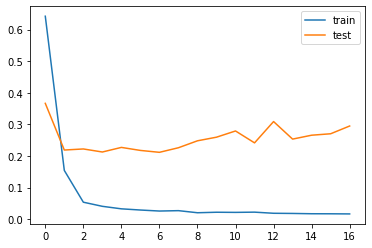

In [567]:
# plot the loss and accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [570]:
#load the best model

model = load_model('../models/Racism_Detector.h5')


scores = model.predict(xvalid_pad)
predicted_lstm = [1 if x > 0.5 else 0 for x in scores]
# decode predictions
print(metrics.classification_report(yvalidgru, predicted_lstm))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       224
           1       0.88      0.88      0.88       181

    accuracy                           0.90       405
   macro avg       0.90      0.90      0.90       405
weighted avg       0.90      0.90      0.90       405



In [571]:
dissagreement = pd.DataFrame({'text': xvalidgru, 'label': yvalidgru, 'predicted': predicted_lstm})

# where the model is wrong

dissagreement[dissagreement.label != dissagreement.predicted]

,text,label,predicted
6,اساسا انتم تدرون ان سلاطين اراضيكم الجاهليه ماضغطونا اظن والله اعلم ان كلمه ساضغط مشتقه ضغط الجزيره مرتفع وظهرت بسببه الكلمه,1,0
10,علموا اولادكم الدين فقط صيام صلاه كلام منمق يلقي المساجد الدين معامله حياه,0,1
15,بالوراثه اليهوذ,1,0
16,ممكن نقبلوه احسن البطبوط,0,1
30,الارهابي بشار الاسد مءيديه داعميه قتله الاطفال معذبي الاطفال سجون النظام السوري الارهابي,1,0
33,امير المءمنين vu,0,1
35,معزه طارت تغلبو الشعوب انتم طرتم بالسماء,0,1
47,كلاب اولهم,0,1
52,Leo Messi هاد السيد مسكين بلاصتو فاحسن الفراقي فالعالم الظروف دارتها بيه راهو دابا كيعاون السيكليس فالكاراج لنتعاطف ليو,0,1
60,نعرف بنادم مزوج msn,0,1


In [572]:
# test model with racism text in arabic

pred  = model.predict(pad_sequences(token.texts_to_sequences(['اذهب لبلدك يا اسود أنت و شعبك المعفن']), maxlen=max_len))
print(pred)

pred  = model.predict(pad_sequences(token.texts_to_sequences(['يا لكحلوش يا كحل لعفتا خرج لينا من بلادنا']), maxlen=max_len))
print(pred)

[[0.7362586]]
[[0.8751169]]


In [573]:
# test model with non racism text in arabic

pred  = model.predict(pad_sequences(token.texts_to_sequences(['سوريا اجمل بلد في العالم']), maxlen=max_len))
print(pred)

[[0.11676189]]


In [538]:
# read a data

data = pd.read_csv('../DataSet/final_dataset.csv', encoding='utf-16')


data.sample(15)

,Comment,Majority_Label
7970,انت مكعب غباء حاقد شو حكي السيد بدك تفهمي هاي جماهير حاقنه وساكته صرلها زمان الشتاءم,1.0
26876,مباينشي عليه الزنقة الله يعطيك مصيبة هاذ مول شوف الخرا,1.0
28344,النبي إبراهيم معيدي شروكي من أور بالقرب من الناصرية وهذا يعني أن أصله هندي,1.0
29466,ياربي استرنا دنيا و آخرة لا حولة ولا قوة الا بالله العلي العظيم 😠,0.0
3968,وشو مقعدك بلبنان طلاع عسوريا,0.0
29330,الا معاك ينفرزو مدري ليش,0.0
28398,لمذا لا يصنعوا محلياً كغزة العزة.فعلا ارجال بتصنع صواريخ وأشباة بتصنع في الكفتة وارجال بتركع للجبار واشباة بتركع للدولار,1.0
24739,الله يمسخك شوهتونا وهداك لمعاك ركب لو كرووون لحولي,0.0
7938,اتعبتيهم لانك صادقه,0.0
28474,مساحة السعودية تسع لملايين السوريين فالسؤال هو لماذا لا تستقبلهم السعودية. انا اعرف هل انتم ايضاً تعرفون?,0.0


In [455]:
# moroccan = data[data['dialect'] == 'morocco']

# moroccan.sample(15)

In [539]:
# clean data

data = data[data['Majority_Label'] == 1]

data['cleaned'] = data['Comment'].apply(cleaning_content)

# delete row if Comment not string

data = data[data['cleaned'].apply(lambda x: isinstance(x, str))]

data

,Comment,Majority_Label,cleaned
4,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم,1.0,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم
9,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,1.0,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس
10,طاءفي روح اسال اهل قانا وهني بخبروك,1.0,طاءفي روح اسال اهل قانا وهني بخبروك
14,غرد الجحش وظن باءنه حصانا تتكلم العوني بموضوعيه فيرد كبهيم حقير جربان اصله,1.0,غرد الجحش وظن باءنه حصانا تتكلم العوني بموضوعيه فيرد كبهيم حقير جربان اصله
16,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,1.0,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو
...,...,...,...
31746,البعض يلومون السعوديه والخليج بعدم ايواء الاجئين السوريين بصراحه انهم يكلفون خزينه المملكه الكثير من المال لكن لم تسألو انفسكم اين سيقضي الملك والحاشيه العطله الصيفيه صج الا ما اختشو ماتو‏!‏,1.0,البعض يلومون السعوديه والخليج بعدم ايواء الاجءين السوريين بصراحه انهم يكلفون خزينه المملكه الكثير المال تسالو انفسكم اين سيقضي الملك والحاشيه العطله الصيفيه صج الا اختشو ماتو‏ ‏
31749,راجل جاتو نفس الرجال عبر عليك على ديك الروتيني كتوري المؤخرة ديالك تستهلي,1.0,راجل جاتو الرجال عبر ديك الروتيني كتوري المءخره ديالك تستهلي
31750,لعندك لجرأة وضحي من دوك جوج قنوات لمسخين ديالك,1.0,لعندك لجراه وضحي دوك جوج قنوات لمسخين ديالك
31752,وأنشأ حنا مسلمين ولا كلاب . اس هادا اشي كيعلوا اولادنا . الله يخليكم بالخلى,1.0,وانشا حنا مسلمين كلاب اس هادا اشي كيعلوا اولادنا الله يخليكم بالخلي


In [457]:
# remove duplicate

data.drop_duplicates(subset=['cleaned'], inplace=True)


In [540]:
# remove row if is in df

data = data[~data['cleaned'].isin(df['text'])]

In [541]:
data

,Comment,Majority_Label,cleaned
4,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم,1.0,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم
18,رايه يوسف علاونه ربي اغفر واعرف انك تغفر اقترح ان نعرض امك طبيب بيطري لنشوف اي جحش ابوك,1.0,رايه يوسف علاونه ربي اغفر واعرف انك تغفر اقترح ان نعرض امك طبيب بيطري لنشوف اي جحش ابوك
20,والله وصاير شعراوي واوي بعرفك حمار بتحكي كلمتين حافظن لتسب العالم,1.0,والله وصاير شعراوي واوي بعرفك حمار بتحكي كلمتين حافظن لتسب العالم
21,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,1.0,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم
23,كول هوا,1.0,كول هوا
...,...,...,...
31742,الناس غادين معاه بنيتهم وهو شلاهبي ولكين الحق غادي يبان,1.0,الناس غادين معاه بنيتهم شلاهبي ولكين الحق غادي يبان
31743,فازوا دون راقصات ولا طبالين ولا مواخير إعلامية، وبكرا حتشوفوا تركيا (-:,1.0,فازوا راقصات طبالين مواخير اعلاميه وبكرا حتشوفوا تركيا
31749,راجل جاتو نفس الرجال عبر عليك على ديك الروتيني كتوري المؤخرة ديالك تستهلي,1.0,راجل جاتو الرجال عبر ديك الروتيني كتوري المءخره ديالك تستهلي
31750,لعندك لجرأة وضحي من دوك جوج قنوات لمسخين ديالك,1.0,لعندك لجراه وضحي دوك جوج قنوات لمسخين ديالك


In [542]:
# predict
def pred(t):
    # tokenize
    t = token.texts_to_sequences(t)
    # pad
    t = pad_sequences(t, maxlen=max_len)
    # predict
    p = model.predict(t)
    return p

In [543]:
# predict on data
data['pred'] = pred(data['cleaned'])


C:\Users\makch\AppData\Local\Temp\ipykernel_10736\2111329806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred'] = pred(data['cleaned'])


In [546]:
# get pred  > 0.7
moroccan_racism = data[data['pred'] < 0.5]

# add column final_label filed with Nan
moroccan_racism['final_label'] = np.nan

moroccan_racism

C:\Users\makch\AppData\Local\Temp\ipykernel_10736\3137039790.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moroccan_racism['final_label'] = np.nan


,Comment,Majority_Label,cleaned,pred,final_label
4,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم,1.0,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم,0.001255,NaN
18,رايه يوسف علاونه ربي اغفر واعرف انك تغفر اقترح ان نعرض امك طبيب بيطري لنشوف اي جحش ابوك,1.0,رايه يوسف علاونه ربي اغفر واعرف انك تغفر اقترح ان نعرض امك طبيب بيطري لنشوف اي جحش ابوك,0.001221,NaN
20,والله وصاير شعراوي واوي بعرفك حمار بتحكي كلمتين حافظن لتسب العالم,1.0,والله وصاير شعراوي واوي بعرفك حمار بتحكي كلمتين حافظن لتسب العالم,0.011087,NaN
21,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,1.0,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,0.084021,NaN
23,كول هوا,1.0,كول هوا,0.035378,NaN
...,...,...,...,...,...
31740,@User.IDX كذب يا خنزيرة حسبي الله ونعم الوكيل فيكم اللهم احفظ مصر من شركم تحيا مصر رغم انف الحاقدين ✌,1.0,كذب خنزيره حسبي الله ونعم الوكيل فيكم اللهم احفظ مصر شركم تحيا مصر رغم انف الحاقدين,0.043495,NaN
31742,الناس غادين معاه بنيتهم وهو شلاهبي ولكين الحق غادي يبان,1.0,الناس غادين معاه بنيتهم شلاهبي ولكين الحق غادي يبان,0.009557,NaN
31749,راجل جاتو نفس الرجال عبر عليك على ديك الروتيني كتوري المؤخرة ديالك تستهلي,1.0,راجل جاتو الرجال عبر ديك الروتيني كتوري المءخره ديالك تستهلي,0.012917,NaN
31750,لعندك لجرأة وضحي من دوك جوج قنوات لمسخين ديالك,1.0,لعندك لجراه وضحي دوك جوج قنوات لمسخين ديالك,0.031921,NaN


In [545]:
from IPython.display import clear_output
# manually check if the comments are racist or not by prompting the user to enter 1 or 0
for i in range(len(moroccan_racism)):

    print(f'comment {i} / text = {moroccan_racism.iloc[i]["Comment"]} , proba = {moroccan_racism.iloc[i]["pred"]}')
    print('---------------------------------------')

    inp = input(f'{i} : {moroccan_racism.iloc[i]["Comment"]} :  proba = {moroccan_racism.iloc[i]["pred"]}')
    if inp == '1':
        moroccan_racism.iloc[i, moroccan_racism.columns.get_loc('final_label')] = 'Racism'
        clear_output()
    elif inp == '0':
        
        moroccan_racism.iloc[i, moroccan_racism.columns.get_loc('final_label')] = 'not racism'
        clear_output()
    elif inp == 'exit':
        break

    print('---------------------------------------')

comment 0 / text = مشحره شو منوب انتي بتضهري لبرا ولك فوتي البرندا احسن يراشقوكي تعون السترات الصفر بالبيض , proba = 0.9978228807449341
---------------------------------------
---------------------------------------
comment 1 / text = عوي عوي , proba = 0.7610166072845459
---------------------------------------
---------------------------------------
comment 2 / text = لانه كلاب عالم متل طارق خوري وغيره , proba = 0.8592387437820435
---------------------------------------
---------------------------------------
comment 3 / text = شو بتلبقلك كلمه خنزير بتجي مفصله قياسك وشكلك , proba = 0.9803733825683594
---------------------------------------
---------------------------------------
comment 4 / text = جوليت چوليت بني ادم براس بهيمه , proba = 0.8091947436332703
---------------------------------------
---------------------------------------
comment 5 / text = كلب انت كلب مجوسي تحكي الانسانيه , proba = 0.883078396320343
---------------------------------------
---------------------------------

In [464]:
annotated = moroccan_racism[moroccan_racism['final_label'].notnull()]

annotated

,Comment,Majority_Label,cleaned,pred,final_label
1,سوريه بلد الحضارات تربطها بعليه او بحيوان,0.0,سوريه بلد الحضارات تربطها بعليه او بحيوان,0.861204,Racism
15,وكل مين بيشد مشدو وكل مين مغطيه,0.0,وكل مين بيشد مشدو وكل مين مغطيه,0.977949,not racism
19,نقول معاليه شو سب نتذكر مين الي علقلو مشنقي طرابلس مين تابعين نتذكر الصور,0.0,نقول معاليه شو سب نتذكر مين الي علقلو مشنقي طرابلس مين تابعين نتذكر الصور,0.968656,not racism
21,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,1.0,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,0.790484,not racism
22,صحيح يجب ان يحضر زرع الورود وضمد الجراح وواكب الشهداء سفاح وقاتل الاطفال كفاكم كذب,0.0,صحيح يجب ان يحضر زرع الورود وضمد الجراح وواكب الشهداء سفاح وقاتل الاطفال كفاكم كذب,0.719338,not racism


In [465]:
# save annotated data only columns ['Comment', 'final_label']
# rename column Comment to text

# annotated.rename(columns={'final_label': 'label', 'Comment' : 'text'}, inplace=True)

# annotated[['text', 'label']].to_csv('../DataSet/semi_assisted_racism_annotated_usingLSTM2.csv', index=False, encoding='utf-16')

C:\Users\makch\AppData\Local\Temp\ipykernel_10736\1619452909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated.rename(columns={'final_label': 'label', 'Comment' : 'text'}, inplace=True)
